<a href="https://colab.research.google.com/github/CatarinaNSSilva/sensitive_data_citizen_science/blob/main/Classification_of_Sensitive_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CatarinaNSSilva/sensitive_data_citizen_science/blob/main/Classification_of_Sensitive_data.ipynb)


SyntaxError: ignored

# Image Classification to detect sensitive data exposure

Sensitive data = human faces and car plates


## Importing libraries and downloading the dataset

In [ ]:
# Importing the necessary libraries
import tensorflow as tf
import numpy as np
import os

# Downloading the dataset
git_folder = "/content/sensitive_data_citizen_science"
if os.path.exists(git_folder) == False:
  !git clone https://github.com/CatarinaNSSilva/sensitive_data_citizen_science.git

training_folder = git_folder + "/dataset/training"
validation_folder = git_folder + "/dataset/validation"

Cloning into 'sensitive_data_citizen_science'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 184 (delta 21), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (184/184), 7.69 MiB | 8.85 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [ ]:
train_sensitive_dir = os.path.join(training_folder + "/sensitive")
train_nonsensitive_dir = os.path.join(training_folder + "/nonsensitive")
validation_sensitive_dir = os.path.join(validation_folder + "/sensitive")
validation_nonsensitive_dir = os.path.join(validation_folder + "/nonsensitive")

# Image Dataset size
print('Total training sensitive images:', len(os.listdir(train_sensitive_dir)))
print('Total training nonsensitive images:', len(os.listdir(train_nonsensitive_dir)))
print('Total validation sensitive images:', len(os.listdir(validation_sensitive_dir)))
print('Total validation nonsensitive images:', len(os.listdir(validation_nonsensitive_dir)))

Total training sensitive images: 55
Total training nonsensitive images: 26
Total validation sensitive images: 13
Total validation nonsensitive images: 7


## Sample Data

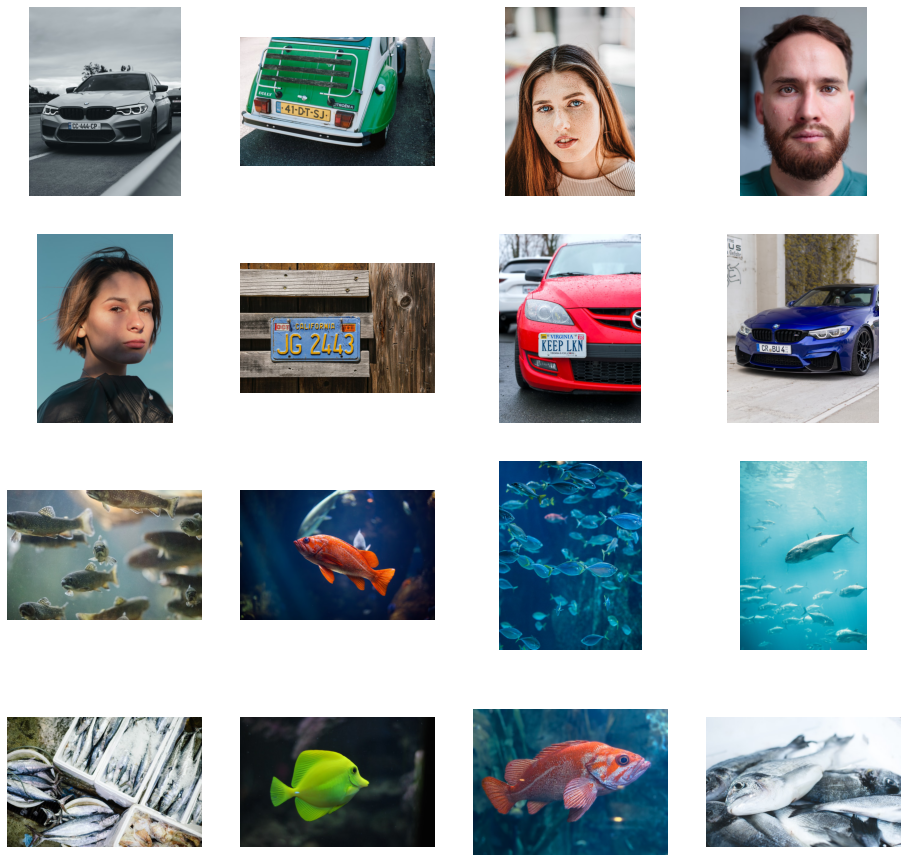

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

train_sensitive_dir = os.path.join(training_folder+"/sensitive")
train_nonsensitive_dir = os.path.join(training_folder+"/nonsensitive")
train_sensitive_names = os.listdir(train_sensitive_dir)
train_nonsensitive_names = os.listdir(train_nonsensitive_dir)

pic_index += 8
next_sensitive_pix = [os.path.join(train_sensitive_dir, fname) 
                for fname in train_sensitive_names[pic_index-8:pic_index]]
next_nonsensitive_pix = [os.path.join(train_nonsensitive_dir, fname) 
                for fname in train_nonsensitive_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_sensitive_pix+next_nonsensitive_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Model

In [ ]:
# Callbacks to cancel training after reaching a desired accuracy
# This is done to avoid overfitting
DESIRED_ACCURACY = 0.98

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached 98% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# Sequential - defines a SEQUENCE of layers in the neural network.
model = tf.keras.models.Sequential([
  # 2D Convolution Layer - Filter, Kernel_size, activation fn
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
  # Max pooling operation for 2D data - Pool size
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # Flattens the input. Does not affect the batch size.
  tf.keras.layers.Flatten(),
  # Regular densely-connected Neural Network layer with ReLU activation function.
  tf.keras.layers.Dense(512, activation='relu'),
  # Regular densely-connected Neural Network layer with sigmoid activation function.
  tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop

# model.compile - Configures the model for training.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Adam -  optimization algorithm used instead of the classical stochastic gradient descent procedure to update network weights.

# Display the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## Preprocessing, Data Augmentation & Training

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescaling - 1/255 is to transform every pixel value from range [0,255] -> [0,1]
# Performing image augmentation for training data
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

# flow_from_directory - Takes the path to a directory & generates batches of data.
train_generator = train_datagen.flow_from_directory(
        training_folder,
        target_size=(150, 150),
        batch_size=5,
        class_mode='binary',
        shuffle=True
       )

validation_generator = validation_datagen.flow_from_directory(
        validation_folder,
        target_size=(150, 150),
        batch_size=2,
        class_mode='binary',
        shuffle=True
        )

num_epochs = 500
# model.fit - Train the model for a fixed number of epochs
history = model.fit(
      train_generator,
      steps_per_epoch=10,
      epochs=num_epochs,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      callbacks=[callbacks])

Found 81 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Epoch 1/500
10/10 [==============================] - 1s 131ms/step - loss: 0.3088 - accuracy: 0.8696 - val_loss: 0.4869 - val_accuracy: 0.8750
Epoch 2/500
10/10 [==============================] - 1s 114ms/step - loss: 0.4394 - accuracy: 0.8043 - val_loss: 0.7799 - val_accuracy: 0.6875
Epoch 3/500
10/10 [==============================] - 1s 120ms/step - loss: 0.5770 - accuracy: 0.8261 - val_loss: 0.7446 - val_accuracy: 0.6875
Epoch 4/500
10/10 [==============================] - 1s 124ms/step - loss: 0.4306 - accuracy: 0.8400 - val_loss: 0.3651 - val_accuracy: 0.8750
Epoch 5/500
10/10 [==============================] - 1s 120ms/step - loss: 0.4595 - accuracy: 0.8478 - val_loss: 0.4828 - val_accuracy: 0.8750
Epoch 6/500
10/10 [==============================] - 1s 118ms/step - loss: 0.4531 - accuracy: 0.8696 - val_loss: 0.7631 - val_accuracy: 0.5625
Epoch 7/500
10/10 [==============================] - 1s 113ms/

## Plotting Accuracy and Loss Functions

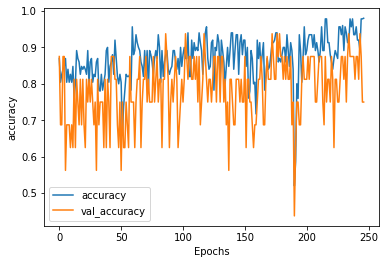

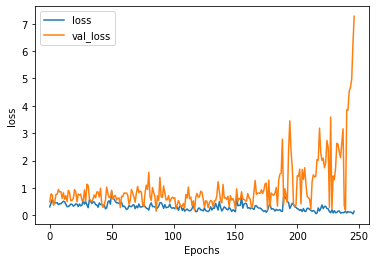

In [ ]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Saving the model

In [ ]:
# Save and convert the model (Used for deploying in web application)
model.save('model/image_model.h5')
print("Saved the model successfully")

!apt-get -qq install virtualenv
!virtualenv -p python3 venv
!source venv/bin/activate
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras /content/model/image_model.h5 /content/image_model
print("Model converted to JSON successfully")

Saved the model successfully
Already using interpreter /usr/bin/python3
Using base prefix '/usr'
New python executable in /content/venv/bin/python3
Not overwriting existing python script /content/venv/bin/python (you must use /content/venv/bin/python3)
Installing setuptools, pkg_resources, pip, wheel...done.
Model converted to JSON successfully


## Test in a few images (not seen by the model before)

Saving Fisherman-Mutton-Snapper-Florida-Cropped-David-Moss.jpeg to Fisherman-Mutton-Snapper-Florida-Cropped-David-Moss.jpeg
[0.]
Fisherman-Mutton-Snapper-Florida-Cropped-David-Moss.jpeg - Non-sensitive


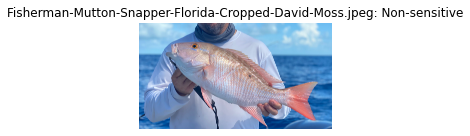

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
result = dict()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " - Sensitive")
    result[fn] = "Sensitive"
  else:
    print(fn + " - Non-sensitive")
    result[fn] = "Non-sensitive"

plt.figure(figsize=(20,20))
   
for i, fn in enumerate(uploaded.keys()):
  image = plt.imread(fn)  
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  plt.imshow(image)
  ans = fn + ": " + result[fn]
  plt.title(ans)

Saving In-Lapland-there-are-more-than-130-000-local-recreational-fishermen-and-260-000-from.png to In-Lapland-there-are-more-than-130-000-local-recreational-fishermen-and-260-000-from (1).png
[0.]
In-Lapland-there-are-more-than-130-000-local-recreational-fishermen-and-260-000-from.png - Non-sensitive


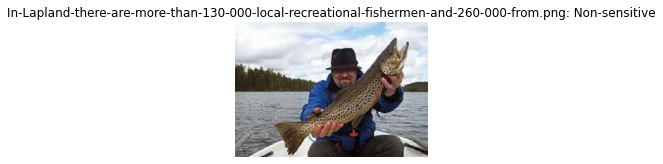

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
result = dict()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " - Sensitive")
    result[fn] = "Sensitive"
  else:
    print(fn + " - Non-sensitive")
    result[fn] = "Non-sensitive"

plt.figure(figsize=(20,20))
   
for i, fn in enumerate(uploaded.keys()):
  image = plt.imread(fn)  
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  plt.imshow(image)
  ans = fn + ": " + result[fn]
  plt.title(ans)

Saving new-number-plate-guide-lead-template-70.jpeg to new-number-plate-guide-lead-template-70.jpeg
[1.]
new-number-plate-guide-lead-template-70.jpeg - Sensitive


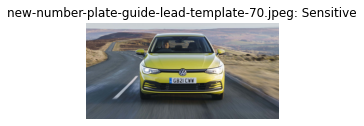

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
result = dict()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " - Sensitive")
    result[fn] = "Sensitive"
  else:
    print(fn + " - Non-sensitive")
    result[fn] = "Non-sensitive"

plt.figure(figsize=(20,20))
   
for i, fn in enumerate(uploaded.keys()):
  image = plt.imread(fn)  
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  plt.imshow(image)
  ans = fn + ": " + result[fn]
  plt.title(ans)

Saving kevin-kyer.jpeg to kevin-kyer.jpeg
[0.]
kevin-kyer.jpeg - Non-sensitive


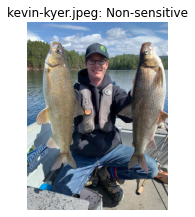

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
result = dict()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " - Sensitive")
    result[fn] = "Sensitive"
  else:
    print(fn + " - Non-sensitive")
    result[fn] = "Non-sensitive"

plt.figure(figsize=(20,20))
   
for i, fn in enumerate(uploaded.keys()):
  image = plt.imread(fn)  
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  plt.imshow(image)
  ans = fn + ": " + result[fn]
  plt.title(ans)

Saving ©FAO_PaoloDeDonno.jpeg to ©FAO_PaoloDeDonno.jpeg
[2.2564333e-23]
©FAO_PaoloDeDonno.jpeg - Non-sensitive


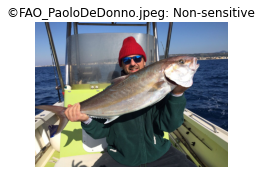

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
result = dict()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " - Sensitive")
    result[fn] = "Sensitive"
  else:
    print(fn + " - Non-sensitive")
    result[fn] = "Non-sensitive"

plt.figure(figsize=(20,20))
   
for i, fn in enumerate(uploaded.keys()):
  image = plt.imread(fn)  
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  plt.imshow(image)
  ans = fn + ": " + result[fn]
  plt.title(ans)

Saving b054c1d617de4ae8884deed224ca999f.png to b054c1d617de4ae8884deed224ca999f.png
[0.]
b054c1d617de4ae8884deed224ca999f.png - Non-sensitive


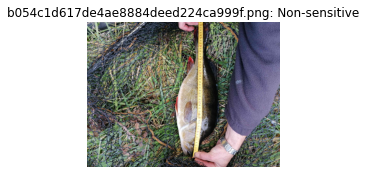

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
result = dict()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " - Sensitive")
    result[fn] = "Sensitive"
  else:
    print(fn + " - Non-sensitive")
    result[fn] = "Non-sensitive"

plt.figure(figsize=(20,20))
   
for i, fn in enumerate(uploaded.keys()):
  image = plt.imread(fn)  
  plt.subplot(5, 5, i+1)
  plt.axis("off")
  plt.imshow(image)
  ans = fn + ": " + result[fn]
  plt.title(ans)